In [44]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.LAST)



data, target = dataloader.get_econmical_classification_dataset_and_target()
vars2drop = ['Time', 'x1', 'x10', 'x14', 'x16', 'x19', 'x2', 'x23', 'x24', 'x25', 'x3', 'x30', 'x32', 'x35', 'x36', 'x40', 'x41', 'x43', 'x44', 'x46', 'x5', 'x59', 'x61', 'x63', 'x64', 'x68', 'x70', 'x73', 'x78', 'x8', 'x9']
data = data.drop(columns=vars2drop)
data_min = data.min()
data = data-data_min

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
project_dir:  /Users/hugojarudd/Desktop/kdd-process/src


In [45]:
from numpy import array, ndarray
from sklearn.model_selection import train_test_split
from pandas import DataFrame, Series, Index, Period

file_tag = target

eval_metric = "f1"

train, test = train_test_split(data, test_size=0.2, random_state=42)

labels: list = list(train[target].unique())
labels.sort()

trnY: array = train.pop(target).to_list()
trnX: ndarray = train.values

tstY: array = test.pop(target).to_list()
tstX: ndarray = test.values

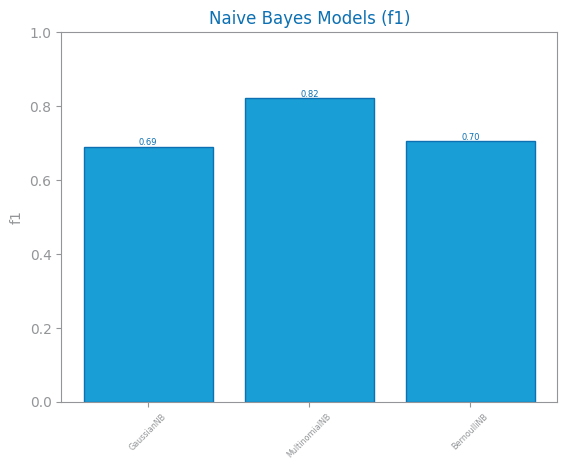

In [46]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
#savefig(f"images/{file_tag}_nb_{eval_metric}_study.png")
show()

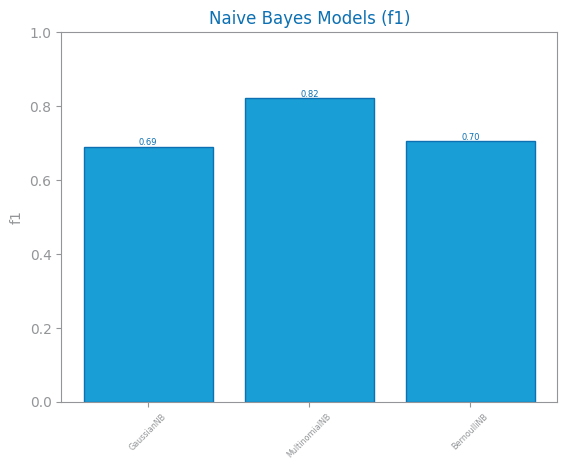

In [47]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "f1")
#savefig(f"images/{file_tag}_nb_recall_study.png")
show()


<Figure size 640x480 with 0 Axes>

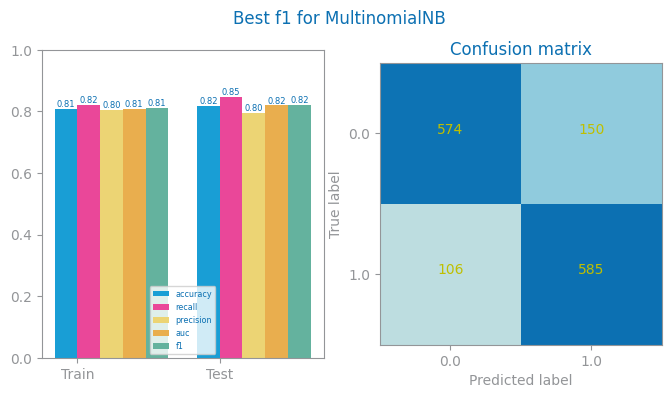

In [48]:
from dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
#savefig(f'images/{file_tag}_{params["name"]}_best_{params["metric"]}_eval.png')
show()